In [2]:
# Importing all usefull libraries
import numpy as np
import matplotlib.pyplot as plt

**Let $x$ and $y$**

In [22]:
# Number of points for each vector
N = 100
# Definition for x and y
x = np.linspace(-5., 5., N)
v1 = x**2 + np.cos(x)
v2 = np.exp(x/2.) + x

In [23]:
# Printing the minimum and maximun values
print 'Using the first data vector:'
print 'Min =', v1.min(), '/', 'Max =', v1.max()
print 'Using the second data vector:'
print 'Min =', v2.min(), '/', 'Max =', v2.max()

Using the first data vector:
Min = 1.00127565114 / Max = 25.2836621855
Using the second data vector:
Min = -4.91791500138 / Max = 17.1824939607


In [24]:
# Calculation of the means
m1 = np.mean(v1)
m2 = np.mean(v2)

In [30]:
# Correlation using x and y as vectors
CC = np.zeros(N)
for n in range(N):
    CC[n] = (np.sum(v1[n]-m1)*(v2[n]-m2))
    CC[n] /= np.sqrt(np.sum(((v1[n]-m1)**2.)*((v2[n]-m2)**2.)))

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


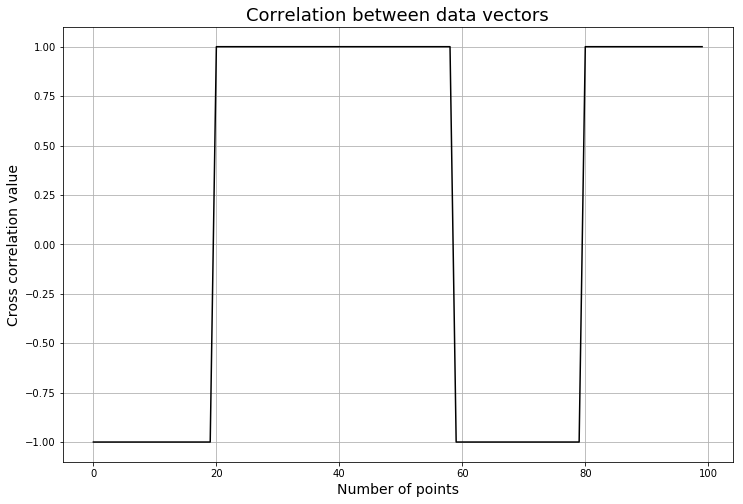

In [39]:
plt.figure(figsize=(12,8))
plt.title('Correlation between data vectors', fontsize = 18)
plt.plot(np.arange(N), CC, 'k-')
plt.xlabel('Number of points', fontsize = 14)
plt.ylabel('Cross correlation value', fontsize = 14)
plt.grid()
plt.show()

In [55]:
# Computing the meshgrid
U, V = np.meshgrid(v1, v2)

In [68]:
nu, mu = U.shape
nv, mv = V.shape
U = U.reshape(U.size)
V = V.reshape(V.size)

In [84]:
# Simple correlation for data vectors v1 e v2
print 'Coeficient:'
print np.corrcoef(v1, v2)
print
print 'Valid method for correlation:', np.correlate(v1, v2, 'valid')
print
print 'Same method for correlation:'
print np.correlate(v1, v2, 'same')
print
print 'Full method for correlation:'
print np.correlate(v1, v2, 'full')

Coeficient:
[[ 1.          0.25603607]
 [ 0.25603607  1.        ]]

Valid method for correlation: [ 3127.54632384]

Same method for correlation:
[ 1499.77664407  1427.88942307  1357.79558424  1289.58077533  1223.33142376
  1159.13640597  1097.08859421  1037.28626898   979.83438621   924.84568959
   872.44166019   822.75329642   775.92171966   732.09860188   691.44641373
   654.13849292   620.35893477   590.30230814   564.17320191   542.18560863
   524.56215363   511.53317924   503.33569527   500.21220806   502.40944182
   510.17696647   523.76574782   543.4266359    569.40880833   601.95818583
   641.31583714   687.71639073   741.38647069   802.54317355   871.39260265
   948.128476    1032.93082237  1125.96478022  1227.37951195  1337.3072458
  1455.86245547  1583.14118679  1719.22053873  1864.15830486  2017.99277925
  2180.74272962  2352.4075383   2532.96751019  2722.38434503  2920.6017696
  3127.54632384  3016.52293321  2910.22153649  2808.24157986  2710.2084185
  2615.77253651  2524.

In [73]:
# Simple correlation for data vectors v1 e v2
print 'Coeficient:'
print np.corrcoef(U,V)
print
print 'Valid method for correlation:', np.correlate(U, V, 'valid')
print
print 'Same method for correlation:'
print np.correlate(U, V, 'same')
print
print 'Full method for correlation:'
print np.correlate(U, V, 'full')

Coeficient:
[[  1.00000000e+00   4.29635997e-18]
 [  4.29635997e-18   1.00000000e+00]]

Valid method for correlation: [ 204354.28917017]

Same method for correlation:
[ 294195.29231742  294218.66854479  294241.02956959 ...,  -89762.90629543
  -89787.77028345  -89813.79592625]

Full method for correlation:
[  434.43637281   850.00567553  1247.026039   ...,  -356.91955302
  -243.28573445  -124.34290155]


In [76]:
# Computing the correlations - vectors
cc_valid = np.correlate(v1, v2, 'valid')
cc_same = np.correlate(v1, v2, 'same')
cc_full = np.correlate(v1, v2, 'full')
# Computing the correlations - grid
CC_valid = np.correlate(U, V, 'valid')
CC_same = np.correlate(U, V, 'same')
CC_full = np.correlate(U, V, 'full')

In [87]:
print 'Minimum values:'
print cc_valid.min(), CC_valid.min()
print cc_same.min(), CC_same.min()
print cc_full.min(), CC_full.min()
print 'Maximum values:'
print cc_valid.max(), CC_valid.max()
print cc_same.max(), CC_same.max()
print cc_full.max(), CC_full.max()

Minimum values:
3127.54632384 204354.28917
-249.580136924 -89813.7959263
-1199.70790683 -92685.5367916
Maximum values:
3127.54632384 204354.28917
3127.54632384 297039.825962
3555.38258715 297039.825962


In [92]:
CC_same = CC_same.reshape(nu, mu)
plt.figure()
plt.contourf(U, V, CC_same, 20, cmap = plt.cm.jet)
plt.colorbar()
plt.show()

TypeError: Length of x must be number of columns in z.

In [79]:
# By using Scipy library
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.correlate.html
from scipy import signal